In [1]:
import torch
import torchtext
from torchtext import data
import torch.optim as optim
import torch.nn as nn
import numpy as np
import argparse
import os
import pandas as pd
from sklearn.model_selection import train_test_split
import torch.nn.functional as F
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

In [2]:
class BaselineModel(torch.nn.Module):
    def __init__(self, vocab, embedding_dim):
        super(BaselineModel,self).__init__()
        self.embedding = nn.Embedding.from_pretrained(vocab.vectors)
        self.linear = nn.Linear(embedding_dim,1)

    def forward(self, x):
        """
        x: torch.tensor of shape (bsz), bsz is the batch size
        """
        out = self.embedding(x)
        out = torch.mean(out,0)
        logits = self.linear(out).squeeze(1)
        return logits

In [3]:
class TextDataset(torch.utils.data.Dataset):
    def __init__(self, vocab, split="train"):
        data_path = "data"
        df = pd.read_csv(os.path.join(data_path, f"{split}.tsv"), sep="\t")

        X, Y = [], []
        V = len(vocab.vectors)
        for i, row in df.iterrows():
            L = row["text"].split()
            X.append(torch.tensor([vocab.stoi.get(w, V-1) for w in L]))  # Use the last word in the vocab as the "out-of-vocabulary" token
            Y.append(row.label)
        self.X = X 
        self.Y = torch.tensor(Y)
        
    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.Y[idx] 

In [4]:
def my_collate_function(batch, device):
    batch_x, batch_y = [], []
    max_len = 0
    for x,y in batch:
        batch_y.append(y)
        max_len = max(max_len, len(x))
    for x,y in batch:
        x_p = torch.concat(
            [x, torch.zeros(max_len - len(x))]
        )
        batch_x.append(x_p)
    return torch.stack(batch_x).t().int().to(device), torch.tensor(batch_y).to(device)

In [5]:
class BaselineModel(torch.nn.Module):
    def __init__(self, vocab, embedding_dim):
        super(BaselineModel,self).__init__()
        self.embedding = nn.Embedding.from_pretrained(vocab.vectors)
        self.linear = nn.Linear(embedding_dim,1)

    def forward(self, x):
        """
        x: torch.tensor of shape (bsz), bsz is the batch size
        """
        out = self.embedding(x)
        out = torch.mean(out,0)
        logits = self.linear(out).squeeze(1)
        return logits

In [6]:
def evaluate(model,batch,criterion,batch_size):
    model.eval()
    with torch.no_grad():
        e_loss = 0.0
        e_acc = 0.0
        p =0
        for text,label in iter(batch):
            logits = model(text)
            label = label.type(torch.float)
            loss = criterion(logits,label)
            acc = ((logits > 0.5)==label).float().sum() 
            e_acc += (acc/batch_size)
            e_loss = e_loss + float(loss)
            p += 1
        return (e_loss/p), (e_acc.cpu()/p)

In [7]:
def Baseline_train(batch_size, epochs, lr, embedding_dim, dataset):
    torch.manual_seed(2)
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print ("Using device:", device)
    glove = torchtext.vocab.GloVe(name="6B",dim=100)

    train_dataset = TextDataset(glove, dataset)
    val_dataset = TextDataset(glove, "validation")
    test_dataset = TextDataset(glove, "test")
    
    # 3.3.3
    train_dataloader = torch.utils.data.DataLoader(
        dataset=train_dataset, 
        batch_size= batch_size, 
        shuffle=False, 
        collate_fn=lambda batch: my_collate_function(batch, device))

    validation_dataloader = torch.utils.data.DataLoader(
        dataset=val_dataset, 
        batch_size= batch_size, 
        shuffle=False, 
        collate_fn=lambda batch: my_collate_function(batch, device))

    test_dataloader = torch.utils.data.DataLoader(
        dataset=test_dataset,
        batch_size= batch_size,
        shuffle=False,
        collate_fn=lambda batch: my_collate_function(batch, device))


    #model = BaselineModel(glove,embedding_dim)
    model = BaselineModel(glove,embedding_dim)
    model = model.to(device)
    criterion = torch.nn.BCEWithLogitsLoss()
    opt_func = torch.optim.Adam
    optimizer = opt_func(model.parameters(), lr)       

    train_loss_list = []
    train_acc_list = []
    val_loss_list = []
    val_acc_list = []
    test_loss_list = []
    test_acc_list = []

    epoch_r = np.arange(0,epochs)
    for epoch in range(epochs):
        train_loss= 0.0
        train_acc= 0.0
        model.train()
        n = 0
        for text,label in iter(train_dataloader): 
            logits = model(text)
            label = label.type(torch.float)
            loss = criterion(logits,label)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            acc = ((logits > 0.5)==label).float().sum()
            train_acc += (acc/batch_size)
            train_loss = train_loss + float(loss)
            n += 1
        train_loss_list.append(train_loss/n)
        train_acc_list.append(train_acc.cpu()/n)

        val = evaluate(model,validation_dataloader, criterion, batch_size)
        val_loss_list.append(val[0])
        val_acc_list.append(val[1])

        print("Epoch: [{}]| Train acc:  {:.4f} | Train loss:  {:.4f} |  Valid acc:  {:.4f} |  Valid loss:  {:.4f} "
          .format(epoch + 1, train_acc_list[epoch], train_loss_list[epoch],val_acc_list[epoch],
                  val_loss_list[epoch]))
    
    test = evaluate(model,test_dataloader, criterion, batch_size)
    test_loss_list.append(test[0])
    test_acc_list.append(test[1])
    print('Test Accuracy:', test_acc_list[-1])
        
    plt.title("Loss Curve")
    plt.plot(epoch_r, train_loss_list, label="Train")
    plt.plot(epoch_r, val_loss_list, label="Validation")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()
    
    plt.title("Accuracy Curve")
    plt.plot(epoch_r, train_acc_list, label="Train")
    plt.plot(epoch_r, val_acc_list, label="Validation")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()
    
    return model

In [19]:
def Baseline_overfit(batch_size, epochs, lr, embedding_dim, dataset):
    torch.manual_seed(2)
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print ("Using device:", device)
    glove = torchtext.vocab.GloVe(name="6B",dim=100)

    train_dataset = TextDataset(glove, dataset)

    train_dataloader = torch.utils.data.DataLoader(
        dataset=train_dataset, 
        batch_size= batch_size, 
        shuffle=False, 
        collate_fn=lambda batch: my_collate_function(batch, device))

    model = BaselineModel(glove,embedding_dim)
    model = model.to(device)
    criterion = torch.nn.BCEWithLogitsLoss()
    opt_func = torch.optim.Adam
    optimizer = opt_func(model.parameters(), lr)       

    train_loss_list = []
    train_acc_list = []

    epoch_r = np.arange(0,epochs)
    for epoch in range(epochs):
        train_loss= 0.0
        train_acc= 0.0
        model.train()
        n = 0
        for text,label in iter(train_dataloader): 
            logits = model(text)
            label = label.type(torch.float)
            loss = criterion(logits,label)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            acc = ((logits > 0.5)==label).float().sum()
            train_acc += (acc/batch_size)
            train_loss = train_loss + float(loss)
            n += 1
        train_loss_list.append(train_loss/n)
        train_acc_list.append(train_acc.cpu()/n)

        print("Epoch: [{}]| Train acc:  {:.4f} | Train loss:  {:.4f} "
          .format(epoch + 1, train_acc_list[epoch], train_loss_list[epoch]))
        
    plt.title("Loss Curve")
    plt.plot(epoch_r, train_loss_list, label="Train")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()
    
    plt.title("Accuracy Curve")
    plt.plot(epoch_r, train_acc_list, label="Train")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()
    
    return model

Using device: cuda
Epoch: [1]| Train acc:  0.5000 | Train loss:  0.6824 |  Valid acc:  0.5000 |  Valid loss:  0.6685 
Epoch: [2]| Train acc:  0.5000 | Train loss:  0.6516 |  Valid acc:  0.5000 |  Valid loss:  0.6401 
Epoch: [3]| Train acc:  0.5016 | Train loss:  0.6252 |  Valid acc:  0.5206 |  Valid loss:  0.6151 
Epoch: [4]| Train acc:  0.5147 | Train loss:  0.6020 |  Valid acc:  0.5681 |  Valid loss:  0.5928 
Epoch: [5]| Train acc:  0.5467 | Train loss:  0.5813 |  Valid acc:  0.6331 |  Valid loss:  0.5729 
Epoch: [6]| Train acc:  0.5898 | Train loss:  0.5628 |  Valid acc:  0.6762 |  Valid loss:  0.5551 
Epoch: [7]| Train acc:  0.6339 | Train loss:  0.5462 |  Valid acc:  0.7131 |  Valid loss:  0.5390 
Epoch: [8]| Train acc:  0.6659 | Train loss:  0.5311 |  Valid acc:  0.7387 |  Valid loss:  0.5244 
Epoch: [9]| Train acc:  0.6916 | Train loss:  0.5175 |  Valid acc:  0.7600 |  Valid loss:  0.5113 
Epoch: [10]| Train acc:  0.7180 | Train loss:  0.5051 |  Valid acc:  0.7750 |  Valid loss:

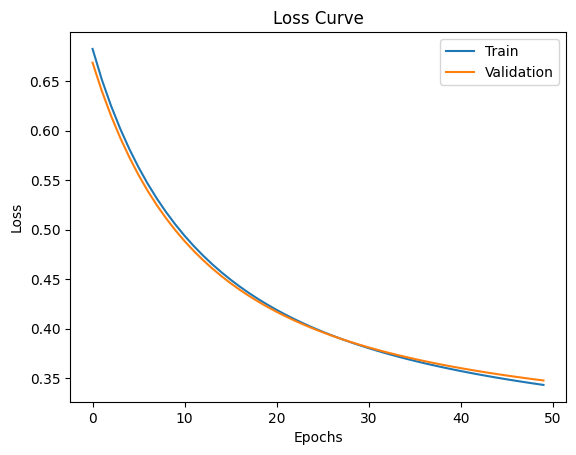

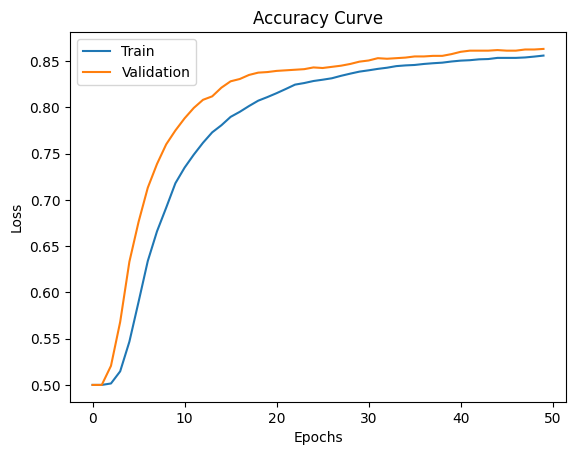

In [8]:
model= Baseline_train(batch_size = 32, epochs = 50, lr = 0.001, embedding_dim = 100, dataset = "train")

Using device: cuda
Epoch: [1]| Train acc:  0.5192 | Train loss:  11.1442 
Epoch: [2]| Train acc:  0.3269 | Train loss:  10.0215 
Epoch: [3]| Train acc:  0.7885 | Train loss:  0.7969 
Epoch: [4]| Train acc:  0.3462 | Train loss:  3.9504 
Epoch: [5]| Train acc:  0.5577 | Train loss:  1.8116 
Epoch: [6]| Train acc:  0.9038 | Train loss:  0.2747 
Epoch: [7]| Train acc:  0.9038 | Train loss:  0.3357 
Epoch: [8]| Train acc:  0.8269 | Train loss:  0.4262 
Epoch: [9]| Train acc:  0.7692 | Train loss:  0.4746 
Epoch: [10]| Train acc:  0.7692 | Train loss:  0.4924 
Epoch: [11]| Train acc:  0.7692 | Train loss:  0.4322 
Epoch: [12]| Train acc:  0.7692 | Train loss:  0.3044 
Epoch: [13]| Train acc:  0.8654 | Train loss:  0.1716 
Epoch: [14]| Train acc:  0.9615 | Train loss:  0.0374 
Epoch: [15]| Train acc:  0.9615 | Train loss:  0.0211 
Epoch: [16]| Train acc:  0.9615 | Train loss:  0.0405 
Epoch: [17]| Train acc:  0.9615 | Train loss:  0.0140 
Epoch: [18]| Train acc:  0.9615 | Train loss:  0.0241

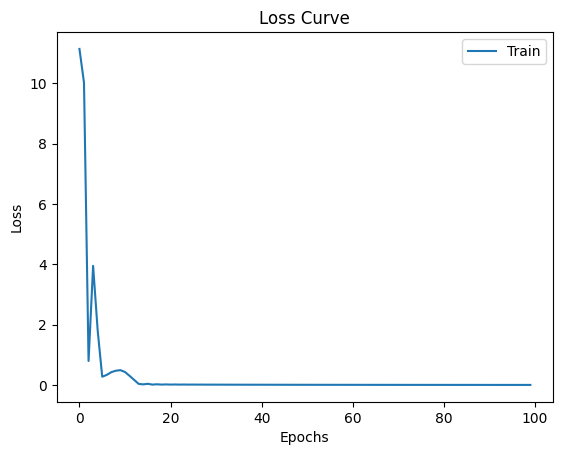

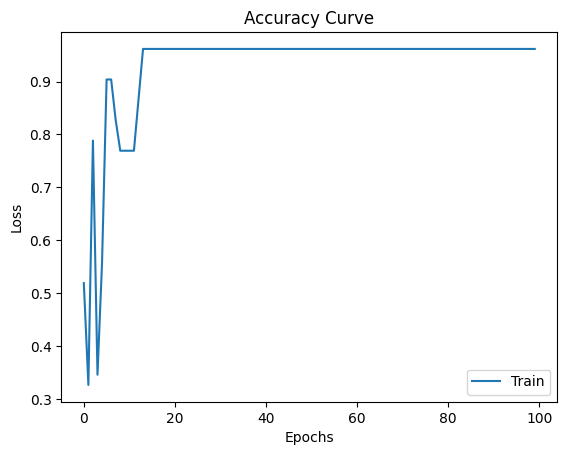

In [25]:
overfit_model= Baseline_overfit(batch_size = 4, epochs = 100, lr = 0.5, embedding_dim = 100, dataset = "overfit")

In [15]:
glove = torchtext.vocab.GloVe(name="6B",dim=100)

In [16]:
weight = model.linear.weight.cpu().squeeze(0).detach()

In [17]:
def print_closest_cosine_words(vec, n=5):
    cos = torch.nn.CosineSimilarity(dim=2)
    dists = cos(glove.vectors.unsqueeze(0), vec.unsqueeze(0))
    dists = dists.squeeze(0)
    lst = sorted(enumerate(dists.numpy()), key=lambda x: x[1], reverse = True) # sort by distance
    for idx, difference in lst[1:n+1]:                         # take the top n
        print(glove.itos[idx], "\t%5.2f" % difference)

In [18]:
print_closest_cosine_words(weight, n =20)

simplistic 	 0.56
pleasing 	 0.55
realistic 	 0.54
insipid 	 0.53
watchable 	 0.53
flattering 	 0.52
disquieting 	 0.52
cheesy 	 0.52
refreshingly 	 0.51
laughable 	 0.51
encapsulates 	 0.51
verisimilitude 	 0.51
cartoonish 	 0.51
engrossing 	 0.51
cartoony 	 0.51
campy 	 0.50
nuanced 	 0.50
bracingly 	 0.50
portentous 	 0.49
ludicrous 	 0.49


In [14]:
torch.save(model.state_dict(), 'model baseline.pt')